In [157]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import tensorflow as tf
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [90]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
tf.test.is_gpu_available()

True

In [91]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x1651c1cca60>)

In [92]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [93]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [94]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [95]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [96]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [97]:
print(total_data.isnull().values.any())

False


In [98]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


<AxesSubplot:>

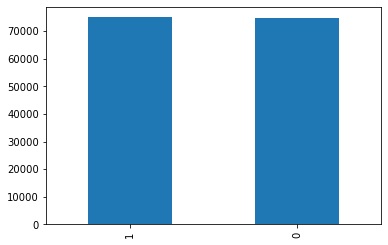

In [99]:
train_data['label'].value_counts().plot(kind = 'bar')

In [100]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


In [101]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

C:\Users\jeonj\AppData\Local\Temp\ipykernel_6388\2976499330.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


ratings    0
reviews    0
label      0
dtype: int64


In [102]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


C:\Users\jeonj\AppData\Local\Temp\ipykernel_6388\2684537507.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [159]:
from eunjeon import Mecab
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [104]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [105]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [106]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [107]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [108]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31823), ('는데', 20095), ('안', 19748), ('어요', 14869), ('있', 13200), ('너무', 13056), ('했', 11796), ('좋', 9797), ('배송', 9623), ('같', 8995), ('거', 8904), ('어', 8896), ('구매', 8884), ('없', 8695), ('아요', 8636), ('습니다', 8436), ('그냥', 8353), ('되', 8350), ('잘', 8029), ('않', 7986)]


In [109]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39365), ('아요', 21151), ('네요', 19906), ('어요', 18672), ('잘', 18612), ('구매', 16175), ('습니다', 13322), ('있', 12380), ('배송', 12263), ('는데', 11579), ('합니다', 9850), ('했', 9806), ('먹', 9453), ('재', 9252), ('너무', 8398), ('같', 7867), ('만족', 7225), ('거', 6485), ('기', 6341), ('어', 6317)]


긍정 리뷰의 평균 길이 : 13.57793982376388
부정 리뷰의 평균 길이 : 17.031380976534344


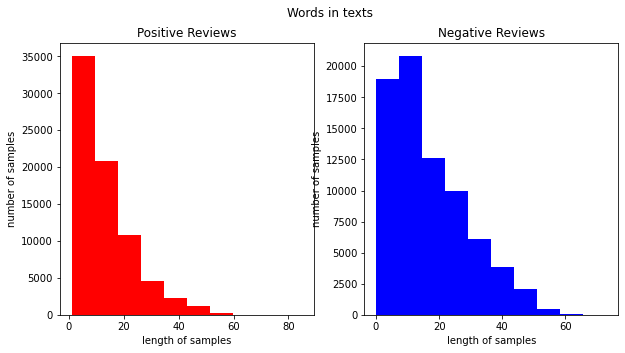

In [110]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [111]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [112]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [113]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39741
등장 빈도가 1번 이하인 희귀 단어의 수: 18056
단어 집합에서 희귀 단어의 비율: 45.43418635665937
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7869324583053495


In [114]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21687


In [115]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [116]:
print(X_train[:3])

[[67, 2067, 301, 14197, 261, 73, 6, 238, 170, 135, 807, 2939, 624, 2, 76, 62, 206, 40, 1356, 155, 3, 6], [479, 405, 53, 8473, 2597, 2373, 338, 2940, 248, 2387, 39, 472, 2], [44, 24, 817, 103, 35, 2374, 160, 7, 10, 8007, 4, 1326, 30, 139, 321, 45, 59, 160, 139, 7, 1935, 2, 113, 161, 1388, 302, 120, 134]]


In [117]:
print(X_test[:3])

[[14, 711, 772, 118, 186, 249, 12], [338, 3902, 62, 3817, 1607], [11, 70, 2, 49, 165, 3, 27, 15, 6, 513, 289, 17, 93, 110, 585, 59, 7, 2]]


리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.303566307167964


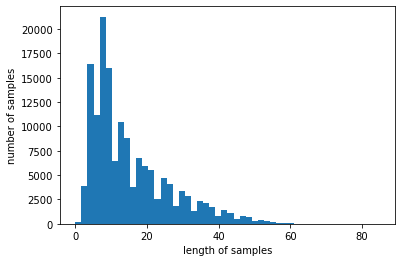

In [118]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [119]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [120]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [121]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [160]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2707 - acc: 0.8981
Epoch 1: val_acc improved from -inf to 0.91436, saving model to best_model.h5
1875/1875 [==============================] - 34s 17ms/step - loss: 0.2707 - acc: 0.8981 - val_loss: 0.2404 - val_acc: 0.9144
Epoch 2/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2149 - acc: 0.9224
Epoch 2: val_acc improved from 0.91436 to 0.92603, saving model to best_model.h5
1875/1875 [==============================] - 31s 16ms/step - loss: 0.2149 - acc: 0.9224 - val_loss: 0.2069 - val_acc: 0.9260
Epoch 3/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.1985 - acc: 0.9290
Epoch 3: val_acc improved from 0.92603 to 0.92660, saving model to best_model.h5
1875/1875 [==============================] - 31s 16ms/step - loss: 0.1985 - acc: 0.9290 - val_loss: 0.2070 - val_acc: 0.9266
Epoch 4/15
1872/1875 [============================>.] - ETA: 0s - loss: 0.1877 - acc: 0.9333
Epoch 4: val_

In [161]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 10s 6ms/step - loss: 0.2087 - acc: 0.9262

 테스트 정확도: 0.9262


In [162]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [170]:
sentiment_predict("택배가 너무 늦잖아요..")

1/1 [==============================] - 13s 13s/step
99.61% 확률로 부정 리뷰입니다.
